In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn import linear_model
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle

import matplotlib.pyplot as plt

# Lasso in Sklearn

## data loading

In [3]:
retmat = pd.read_csv("replicatingHDG.dat", sep = " ")

X = retmat.copy()
X = X.drop(labels = "HDG", axis=1)

y = retmat["HDG"]

In [4]:
X.shape

(183, 1961)

## Lasso in Sklearn with LassoCV

In [5]:
from sklearn.linear_model import LassoCV

n_folds = 10
clf3 = LassoCV(n_alphas = 100, cv = n_folds, normalize = True)
clf3.fit(X, y);

## Graphic visualization of CV MSE vs $\alpha$ level

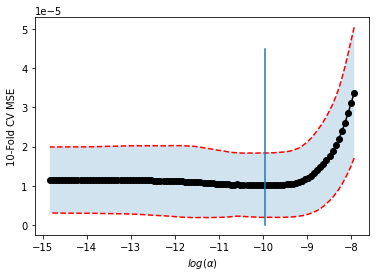

In [6]:
alpha_range = clf3.alphas_
mse_values = clf3.mse_path_.mean(axis = 1)
sd_values = clf3.mse_path_.std(axis = 1)

plt.plot(np.log(alpha_range), mse_values ,"k-o")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.plot([np.log(clf3.alpha_)]*2, [0,.000045])
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("10-Fold CV MSE");

In [7]:
plt.show()

## Sparse $\beta$ statistics from Optimal Model
Note: Sklearn takes the model with $\alpha_\text{min}$

In [8]:
# beta values
clf3.coef_

summary_table = pd.DataFrame({
    "names": np.array(retmat.columns)[:-1],
    "beta values": clf3.coef_
}, columns = ["names","beta values"])


summary_table

,names,beta values
0,DDD,0.0
1,MMM,0.0
2,AHC,0.0
3,AIR,0.0
4,AAN,0.0
...,...,...
1956,YPF,0.0
1957,YUM,0.0
1958,ZBH,0.0
1959,ZF,0.0


In [9]:
# beta values
clf3.coef_

summary_table = pd.DataFrame({
    "names": np.array(retmat.columns)[:-1][clf3.coef_!=0],
    "beta values": clf3.coef_[clf3.coef_!=0]
}, columns = ["names","beta values"])


summary_table

,names,beta values
0,GCH,0.019153
1,JEQ,0.001663
2,AFL,0.008402
3,B,0.000247
4,BDC,0.012896
5,BIO,0.001029
6,CII,0.006733
7,BGY,0.008492
8,CBG,0.012403
9,CEB,0.002052


# R 

The version that is better.

### Data

In [10]:
import rpy2
%load_ext rpy2.ipython

In [11]:
%%R -i retmat
retmat = as.matrix(retmat)

### glmnet code

In [12]:
%%R
library(glmnet)

# Get the data for the stock under consideration
# Note that the final column holds the response

glmnetout = glmnet(retmat[,-1962], retmat[,1962])


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: foreach

R[write to console]: Loaded glmnet 2.0-16




In [13]:
%%R
# Use cross-validation to choose optimal lambda. Note that this procedure is random.
set.seed(0)

cvglmout = cv.glmnet(retmat[,-1962], retmat[,1962])


### Plots

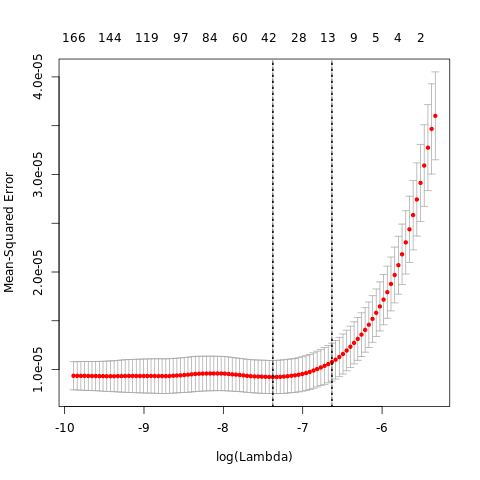

In [14]:
%%R
plot(cvglmout,lwd=2)
abline(v=log(cvglmout$lambda.min),lty=3,lwd=2)
abline(v=log(cvglmout$lambda.1se),lty=3,lwd=2)

In [15]:
%%R
beta_lasso = coef(glmnetout, s=cvglmout$lambda.1se)
beta_lasso = coef(glmnetout, s=cvglmout$lambda.min)


print(beta_lasso)


1962 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -2.805121e-04
DDD          .           
MMM          .           
AHC          .           
AIR          .           
AAN          .           
ABB          .           
ABT          .           
ANF          .           
GCH          1.975927e-02
JEQ          1.746771e-03
SGF          7.852637e-05
ABM          .           
AKR          .           
ACN          .           
ACCO         .           
ACW          .           
ACE          .           
ATV          .           
ATU          .           
AYI          .           
ADX          .           
PEO          .           
AGRO         .           
AAP          .           
ASX          .           
AAV          .           
ATE          .           
AVK          .           
AGC          .           
LCM          .           
ACM          .           
ANW          .           
AEB          .           
AED          .           
AEG          .      

In [16]:
%%R

beta_lasso_nz = beta_lasso[beta_lasso!=0]
names(beta_lasso_nz) = names(beta_lasso)[beta_lasso!=0]
print(beta_lasso_nz)



R[write to console]: <sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



 [1] -2.805121e-04  1.975927e-02  1.746771e-03  7.852637e-05  8.491896e-03
 [6]  3.775309e-04  1.286835e-02  1.110791e-03  7.592048e-03  8.559218e-03
[11]  1.255827e-02  2.031771e-03  2.104938e-03  4.346245e-03  1.268801e-03
[16]  2.380350e-03  1.268544e-03  1.133945e-02  4.705952e-04  2.438465e-03
[21]  1.318186e-02  5.136862e-03  4.012429e-03  1.852220e-03  1.917959e-03
[26]  1.186726e-02  1.340265e-02  4.568427e-02  2.747772e-03  4.189196e-03
[31]  2.419030e-03  1.480231e-03  1.661092e-03  3.523472e-03  1.257682e-03
[36]  1.753219e-03  5.149512e-03  1.095027e-02  2.700013e-03  3.579002e-02
[41]  3.184056e-03  2.367063e-03


---
